# Investigating Hybrid Strategies for Systematic Literature Review
**Experiment 1**

This notebook displays:

1. Citation Matrix;
2. Matrix of Indication of Steps to find the selected articles;
3. Graph of Indication of Steps to find the selected articles;
4. Backward and Forward Matrix.

Note: Citation Graph --> CitationGraph.ipynb

In [1]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years, find_citation
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
from collections import OrderedDict
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [2]:
selected = [(varname, w) for varname, w in load_work_map_all_years() if w.category == "snowball"]
names = [varname for varname, w in selected]
#names

In [3]:

order = OrderedDict([
('hinley1995a', 0),
('reiblein1997a', 1),
('mccoy1998a', 2),
('messnarz1999a', 3),
('sommerville1999a', 4),
('kautz2000a', 5),
('debou2000a', 6),
('waina2001a', 7),
('karlström2002a', 8),
('murugappan2003a', 9),
('trienekens2004a', 10),
('trienekens2005a', 11),
('wang2005a', 12),
('liu2005a', 13),
('liu2006a', 14),
('wilkie2007a', 15),
('basili2007a', 16),
('basili2007c', 17),
('basili2007b', 18),
('martins2007b', 19),
('becker2008a', 20),
('martins2008a', 21),
('becker2008b', 22),
('trienekens2009a', 23),
('albuquerque2009a', 24),
('kowalczyk2010a', 25),
('sun2010a', 26),
('barreto2010a', 27),
('armbrust2010a', 28),
('guzmán2010a', 29),
('basili2010a', 30),
('mandić2010d', 31),
('mcloughlin2010a', 32),
('mcloughlin2010b', 33),
('mandić2010a', 34),
('mandić2010b', 35),
('armbrust2010b', 36),
('trendowicz2011a', 37),
('kaneko2011a', 38),
('birkhölzer2011a', 39),
('plösch2011a', 40),
('esfahani2011a', 41),
('stallinger2013a', 42),
('münch2013c', 43),
('münch2013a', 44),
('trendowicz2014a', 45),
('cocozza2014a', 46),
('unterkalmsteiner2014a', 47),
('lepmets2014a', 48),
('petersen2015a', 49),
('oConnor2015a', 50),
])

id_to_varname = OrderedDict(sorted([
  (index, varname) for varname, index in order.items()
]))

#print (id_to_varname)
selected = [(varname, work_by_varname(varname)) for index, varname in id_to_varname.items()]
names = ['{} S{}'.format(w.year, order[varname] + 1) for varname, w in selected]

#print (names)

#from snowballing.dbmanager import insert, set_attribute
#for key, value in order.items():
#    set_attribute(key, "selected_order", "{}".format(value + 1))

#w.name, w.authors, w.year, varname, "S" + w.selected_order) 

lista = [(w.name, w.authors, w.year, varname, 'S{}'.format(order[varname] + 1), names) for varname, w in selected]
df = pd.DataFrame (lista)
df

#df = df[[ 0, 1, 2, 3, 4]]
#df.columns = ['Title', 'Authors', 'Year', 'Metakey', 'Study']
#df1 = df.sort_values(by = ['Year', 'Study'], ascending=True)

df = df[[ 0, 1, 2, 3, 4]]
df.columns = ['Title', 'Authors', 'Year', 'Metakey', 'Study']
df["study2"] = df["Study"].apply(lambda x: int(x[1:]))
df1 = df.sort_values(by = ['Year', 'study2'], ascending=True)
del df1['study2']
del df['study2']

#df1 = df.groupby('Year').apply(lambda x: x.sort_values(by = ['Year', 'Study', ascending = True))

df1

df1_style = df1.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    dict(selector="th", props=[("text-align", "left")]),
])
print ('\n \033[1m Selected Studies \033[0m')
df1_style


  Selected Studies 


,Title,Authors,Year,Metakey,Study
0,A goal-oriented approach for managing software process change,"Hinley, DS and Reiblein, S",1995,hinley1995a,S1
1,SPI:I can't get no satisfaction-directing process improvement to meet business needs,"Reiblein, Susan and Symons, Andy",1997,reiblein1997a,S2
2,"Interfacing three complementary technologies: strategic planning, process modeling, and system dynamics","McCoy, WL",1998,mccoy1998a,S3
3,Better Software Practice for Business Benefit: Principles and Experiences,"Messnarz, Richard and Tully, Colin J",1999,messnarz1999a,S4
4,Managing process inconsistency using viewpoints,"Sommerville, Ian and Sawyer, Peter and Viller, Stephen",1999,sommerville1999a,S5
5,Applying and adjusting a software process improvement model in practice: the use of the IDEAL model in a small software enterprise,"Kautz, Karlheinz and Hansen, Henrik Westergaard and Thaysen, Kim",2000,kautz2000a,S6
6,Linking software process improvement to business strategies: experiences from industry,"Debou, Christophe and Kuntzmann-Combelles, Annie",2000,debou2000a,S7
7,A business goal-based approach to achieving systems engineering capability maturity,"Waina, RB",2001,waina2001a,S8
8,Aggregating viewpoints for strategic software process improvementa method and a case study,"Karlström, Daniel and Runeson, Per and Wohlin, Claes",2002,karlström2002a,S9
9,Blending CMM and Six Sigma to meet business goals,"Murugappan, Mala and Keeni, Gargi",2003,murugappan2003a,S10


# Citation Matrix

1. The line identifies the article references were found via backward.
2. The column identifies who cited it via forward.
3. The "-" indicates that it is not possible for the article in the row to have references (cite) the article in the column, due to the year of publication.

In [4]:
matrix1 = [
    [varname] + ['-' if cited.year > citer.year else 
     'x' if find_citation(citer, cited) else ''
     for _, cited in selected]
     for varname, citer in selected
]
df = pd.DataFrame(matrix1)
#df.set_index(names)
df.set_axis(names, axis=0, inplace=True)
df.set_axis(["id"] + names, axis=1, inplace=True)
df = df.rename_axis("cited", axis="columns")
df = df.rename_axis("ref", axis="rows")
def highlight_max(s):
    return [
        'background-color: grey' if k == s.name else
        'background-color: green' if v == 'x' else ''
        for k, v in s.iteritems()
    ]
df_style = df.style.apply(highlight_max).set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df_style

In [5]:
with open("output/table.html", "wb") as html:
    html.write(df_style.render().encode("utf-8"))

In [6]:
# [row[0]]
nmatrix = [[(1 if x == 'x' else float('inf')) for x in row[1:]]
 for row in matrix1]
for i, row in enumerate(nmatrix):
    for j, v in enumerate(row):
        if v == 1:
            nmatrix[j][i] = 1
        if i == j:
            nmatrix[i][j] = 0
pmax = 1
size = len(matrix1)
for k in range(size):
    for i in range(size):
        for j in range(size):
            if nmatrix[i][j] > nmatrix[i][k] + nmatrix[k][j]:
                nmatrix[i][j] = nmatrix[j][i] = nmatrix[i][k] + nmatrix[k][j]
                pmax = max(pmax, nmatrix[i][j])

pmax

13

# Matrix - Steps to Find Selected Article

Number of steps to find an article from the list of selected, through the articles found in the references and by whom cites it.
legend = inf - infinite steps

In [7]:
matrix3 = [
    [s[0]] + row
     for s, row in zip(selected, nmatrix)
]
df = pd.DataFrame(matrix3)
#df.set_index(names)
df.set_axis(names, axis=0, inplace=True)
df.set_axis(["id"] + names, axis=1, inplace=True)
df = df.rename_axis("cited", axis="columns")
df = df.rename_axis("ref", axis="rows")
def highlight_max(s):
    return [
        'background-color: grey' if k == s.name else
        'background-color: green' if v != float('inf') and isinstance(v, float) else ''
        for k, v in s.iteritems()
    ]
df_style = df.style.apply(highlight_max).set_properties(**{'text-align': 'center'}).set_table_styles([
    dict(selector="th", props=[("text-align", "center")]),
])
df_style

# Graph Citation - Steps to Find Selected Article

Floyd-Warshall algorithm was used to generate the graph: Determines the distance between all the pairs of vertices of a graph and identify steps to find selected articles.
legend: (color green) - is final selected, (color lightgreen) - not is final selected, (*) - is seed set.

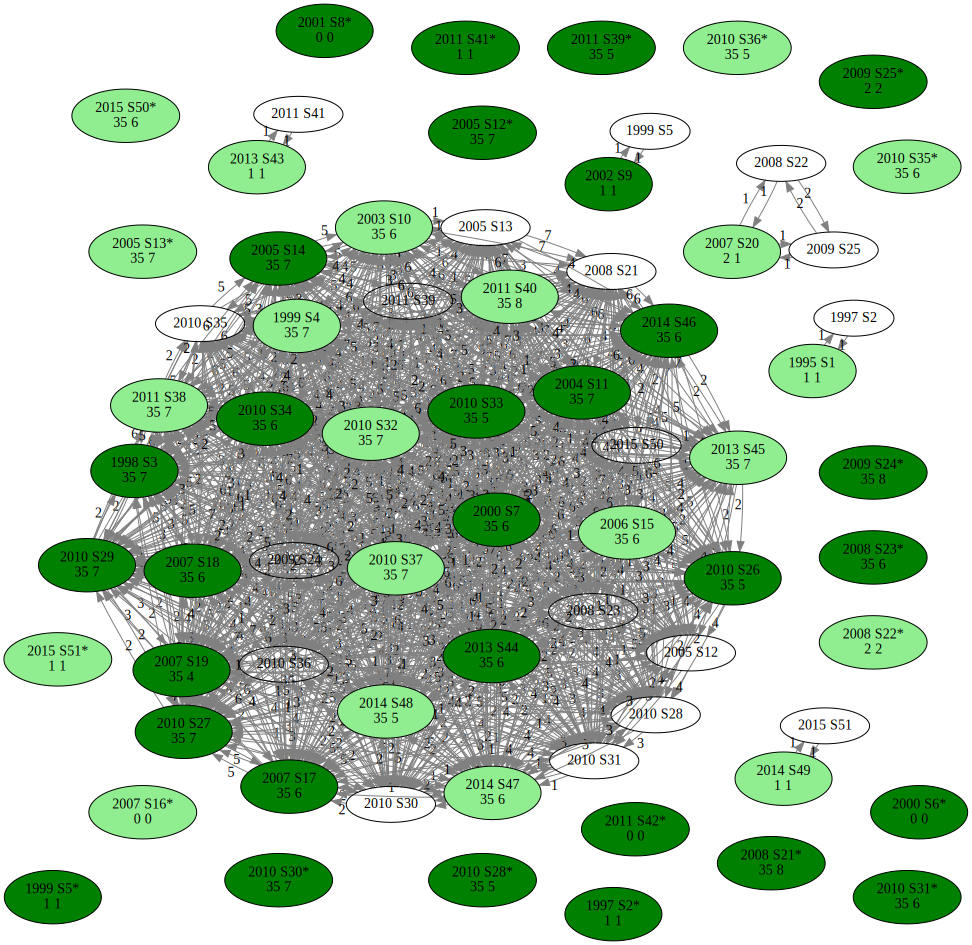

In [8]:
from subprocess import Popen, PIPE as P
class ViewMatrix:
    def __init__(self, nmatrix, names):
        self.nmatrix = nmatrix
        self.names = names
        
    @property
    def dot(self):
        text = ["digraph G {", "graph [ overlap=false ]"]
        for i, name in enumerate(self.names):
            filtered = [x for j, x in enumerate(self.nmatrix[i]) if x != float('inf') if j != i]
            total = sum(1 for x in filtered)
            maxsteps = max(filtered) if filtered else 0
            work = work_by_varname(id_to_varname[int(self.names[i].split()[-1][1:]) - 1])
            color = "green" if getattr(work, 'final_selected', 0) else "LightGreen"
            nameseed = name + "*"
            name = nameseed if getattr(work, 'seed_set', 0) else name
            #color = "green" if {x for _, x in load_work_map_all_years() if x.category == "snowball"} else "white"
            text.append(f'"{name}" [fillcolor="{color}", style=filled, label="{name}\n{total} {maxsteps}"];')
        for i, lis in enumerate(self.nmatrix):
            for j, v in enumerate(lis):
                if v != float('inf') and j != i:
                    text.append('"{}" -> "{}" [label="{}" color="gray"]'.format(self.names[i], self.names[j], v))
        text.append("}")
        return '\n'.join(text)

    def _ipython_display_(self):
        from IPython.display import display
        bundle = {}

        dot = self.dot
        bundle['text/vnd.graphviz'] = dot

        try:
            kwargs = {} if os.name != 'nt' else {"creationflags": 0x08000000}
            p = Popen(['neato', '-T', "svg", "-Goutputorder=edgesfirst"], stdout=P, stdin=P, stderr=P, **kwargs)
            image = p.communicate(dot.encode('utf-8'))[0]
            bundle['image/svg+xml'] = image.decode("utf-8")
        except OSError as e:
            print(e)
            if e.errno != os.errno.ENOENT:
                raise

        display(bundle, raw=True)
m = ViewMatrix(nmatrix, names)
m

# Backward and Forward - Details

1. Number of articles visited and how many steps was used to find the article from the list of selected; 
2. Number of articles found via backward and how many were selected;
3. Number of articles found via forward and how many were selected.

In [9]:
strategy = Strategy({})
matrix2 = [[
    "S", "varname", "visits", "steps",
    "total backward", "selected backward",
    "total forward", "selected forward",
    "backward list", "selected backward list",
    "forward list", "selected forward list"
] + ["Step {}".format(i + 1) for i in range(pmax)]]
for varname, index in order.items():
    work = work_by_varname(varname)
    backward = strategy.ref[work]
    selected_backward = [x for x in backward if x.category == "snowball"]
    forward = strategy.rev_ref[work]
    selected_forward = [x for x in forward if x.category == "snowball"]
    steps = [[] for x in range(pmax)]
    for i, v in enumerate(nmatrix[index]):
        if v != float('inf') and v != 0:
            steps[v - 1].append(id_to_varname[i])
    steps = [", ".join(s) for s in steps]
    filtered = [x for j, x in enumerate(nmatrix[index]) if x != float('inf') if j != i]
    total = sum(1 for x in filtered)
    maxsteps = max(filtered) if filtered else 0
    row = [
        "S{}".format(index + 1), varname,
        total, maxsteps,
        len(backward), len(selected_backward),
        len(forward), len(selected_forward),
        ", ".join(x.metakey for x in backward),
        ", ".join(x.metakey for x in selected_backward),
        ", ".join(x.metakey for x in forward),
        ", ".join(x.metakey for x in selected_forward),
    ] + steps
    
    matrix2.append(row)
pd.set_option('display.max_colwidth',50)
pd.set_option('display.max_colwidth',1000)
df = pd.DataFrame(matrix2)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,S,varname,visits,steps,total backward,selected backward,total forward,selected forward,backward list,selected backward list,forward list,selected forward list,Step 1,Step 2,Step 3,Step 4,Step 5,Step 6,Step 7,Step 8,Step 9,Step 10,Step 11,Step 12,Step 13
1,S1,hinley1995a,2,1,16,0,1,1,"koch1992a, kellner1991a, lientz1980a, rands1992a, tully1989a, humphrey1991b, drew1993a, hinley1993a, shepperd1990a, kellner1989a, hinley1992a, humphrey1989c, hinley1993b, basili1984b, rombach1987a, gilb1988a",,reiblein1997a,reiblein1997a,reiblein1997a,,,,,,,,,,,,
2,S2,reiblein1997a,2,1,15,1,10,0,"hinley1995a, itil1989a, miller1995a, hinley1997a, kaplan1993a, kaplan1996b, deming1986a, vlasveld1995a, iso1994a, trade1992a, humphrey1989a, isoies1997a, iso1994b, group1997a, cmm1993a",hinley1995a,"alshawi2007a, halloran1999a, baddoo2001a, stelzer1998b, schalken2007a, donkin2002a, murakami2007a, brouwer2007a, bowers2001a, makipaa2004a",,hinley1995a,,,,,,,,,,,,
3,S3,mccoy1998a,36,7,5,0,2,2,"dod1996a, blackerby1993a, madni1998a, dynsys1998a, kapp1998a",,"becker2008a, becker2008b","becker2008a, becker2008b","becker2008a, becker2008b","messnarz1999a, liu2005a, sun2010a, barreto2010a, armbrust2010a, armbrust2010b","liu2006a, basili2007b, birkhölzer2011a","kowalczyk2010a, mcloughlin2010a, mandić2010b, kaneko2011a, unterkalmsteiner2014a","debou2000a, murugappan2003a, basili2007a, basili2007c, basili2010a, mcloughlin2010b, mandić2010a, münch2013c, trendowicz2014a, cocozza2014a, petersen2015a","trienekens2004a, trienekens2005a, wang2005a, guzmán2010a, mandić2010d, trendowicz2011a, münch2013a",trienekens2009a,,,,,,
4,S4,messnarz1999a,36,7,0,0,39,1,,,"niazi2005a, dyba2005a, niazi2005b, abrahamsson2001a, komi2004a, komi2004a, becker2008b, messnarz2012a, messnarz2009a, abrahamsson2007a, emam2001b, spork2008a, rose2008a, kettunen2010a, pries2003a, hrastnik2004a, messnarz2011a, messnarz2006a, messnarz2010a, barafort2011a, messnarz2011b, riel2010b, mccaffery2013a, emam2001c, biró2006a, content2004a, biro1999a, connor2011a, stolfa2017a, messnarz2010b, connor2015a, kreiner2016a, area1999a, barafort2014a, winkler2012a, rose2015a, guzmán9999a, area1999a, messnarz9999a",becker2008b,becker2008b,"mccoy1998a, liu2005a, sun2010a, barreto2010a, armbrust2010a, armbrust2010b","liu2006a, basili2007b, becker2008a, birkhölzer2011a","kowalczyk2010a, mcloughlin2010a, mandić2010b, kaneko2011a, unterkalmsteiner2014a","debou2000a, murugappan2003a, basili2007a, basili2007c, basili2010a, mcloughlin2010b, mandić2010a, münch2013c, trendowicz2014a, cocozza2014a, petersen2015a","trienekens2004a, trienekens2005a, wang2005a, guzmán2010a, mandić2010d, trendowicz2011a, münch2013a",trienekens2009a,,,,,,
5,S5,sommerville1999a,2,1,37,0,55,1,"finkelstein1994a, fuggetta1996a, hammer1990a, humphrey1988a, paulk1993c, haase1994a, emam1997a, sommerville1997a, emmet1996a, sommerville1997b, sommerville1998a, osterweil1987a, fernstro1993a, sutton1997a, paulk1995a, sommerville1996a, cugola1996a, conradi1995a, checkland1981a, mullery1979a, kotonya1992a, kotonya1995a, sommerville1995a, basili2006a, checkland1990a, rombach1991a, bro1995a, becker1997a, vertage1994a, bandinelli1995a, bandinelli1993a, madhavji1994a, heineman1994a, turgeon1996a, finkelstein1992a, nuseibeh1994a, easterbrook1996a",,"karlström2002a, marcus2005a, kandé2000a, sawyer2002a, liu2008a, katz2004a, ghose2007a, gans2003a, karlström2005a, ghose2007b, kabbaj2008a, egorova2009a, marcelloni2001a, easterbrook2001a, yang2007a, zhang2009a, acharya2005a, nguyen2003a, taipale2007a, rayson1999a, rayson2000a, katz2004b, rayson1999b, bent2006a, kim2014a, rayson1999c, soares2012a, zhang2010a, nguyen2004a, müller2012a, eljabiri2012a, michel2009a, aysolmaz2011a, eljabiri2001a, berkovich2012a, nunn2016a, morisio2009a, aida2003a, charrel2007a, jun2007a, jurczuk2017b, jesko9999a, solaimani2017a, jurczuk2017a, karlström2002b, lui2008a, nair2009a, francalanci2016a, ghose9999a, solaimani2014a, zhiping

In [10]:
df.to_excel("tabela_grafo.xlsx")

In [11]:
#nmatrix[13]